In [1]:
from pandas_datareader import data as pdr
import datetime
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log, polyfit, sqrt, std, subtract

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm

from pykalman import KalmanFilter
from scipy.optimize import minimize

Get a list of companies sector wise

In [2]:
fmcg = ["PG", "PEP", "KO", "CL", "MNST", "GIS", "MDLZ", "K", "KHC", "HSY", "JNJ", "PM", "SJM", "CPB"]
tech = ["AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "CRM", "ADBE", "AMD", "ORCL", "INTC", "CSCO", "QCOM"]
pharma = ["JNJ", "PFE", "MRK", "ABBV", "LLY", "BMY", "GILD", "AMGN", "CVS", "UNH", "HUM", "CI", "MDT", "SYK"]
bank = ["JPM", "BAC", "C", "WFC", "GS", "MS", "USB", "PNC", "TFC", "COF", "BK", "STT", "SCHW", "AXP", "DFS"]


In [3]:
train_start = datetime.datetime(2010,1,1)
train_end = datetime.datetime(2018,12,31)

def download(arr):
    return yf.download(arr, train_start, train_end)['Close']

train_fmcg = download(fmcg)
train_tech = download(tech)
train_pharma = download(pharma)
train_bank = download(bank)


[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  15 of 15 completed


In [4]:
sectors = [train_fmcg, train_bank, train_pharma, train_tech]
for i in sectors:
    nan_count_per_column = i.isna().sum()
    print(nan_count_per_column[nan_count_per_column!=0])

Ticker
KHC    1384
dtype: int64
Series([], dtype: int64)
Ticker
ABBV    754
dtype: int64
Ticker
META    599
TSLA    122
dtype: int64


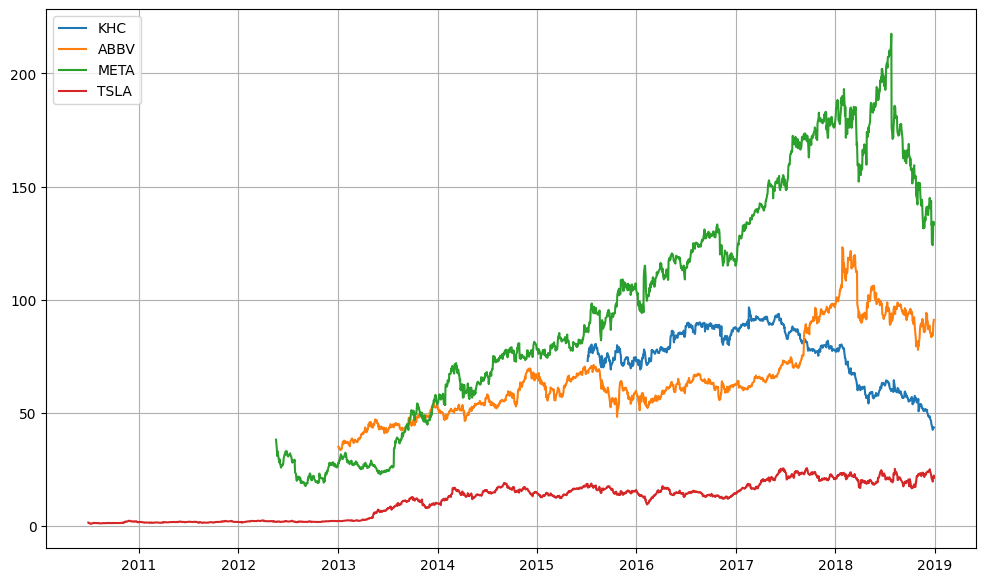

In [5]:
nan_stocks = [train_fmcg['KHC'], train_pharma['ABBV'], train_tech['META'], train_tech['TSLA']]
plt.figure(figsize=(12,7))
for i in nan_stocks:
    plt.plot(i)
plt.legend(['KHC', 'ABBV', 'META', 'TSLA'])
plt.grid()

Removing the stocks with NaN values

In [6]:
train_fmcg.drop('KHC', axis=1, inplace=True)
train_pharma.drop('ABBV', axis=1, inplace=True)
train_tech.drop('META', axis=1, inplace=True)
train_tech.drop('TSLA', axis=1, inplace=True)


In [7]:
train_comb = pd.concat(sectors, axis=1)
train_comb = train_comb.loc[:, ~train_comb.columns.duplicated()]
train_comb

Ticker,CL,CPB,GIS,HSY,JNJ,K,KO,MDLZ,MNST,PEP,...,AMZN,AVGO,CRM,CSCO,GOOGL,INTC,MSFT,NVDA,ORCL,QCOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,41.424999,33.869999,35.450001,36.220001,64.680000,49.605633,28.520000,27.430000,3.273333,61.240002,...,6.695000,1.886000,18.705000,24.690001,15.684434,20.879999,30.950001,0.46225,24.850000,46.939999
2010-01-05,41.759998,33.930000,35.119999,37.169998,63.930000,49.718311,28.174999,28.770000,3.285833,61.980000,...,6.734500,1.900000,18.625000,24.580000,15.615365,20.870001,30.959999,0.46900,24.820000,48.070000
2010-01-06,41.665001,33.549999,35.330002,36.849998,64.449997,49.727699,28.165001,28.969999,3.354167,61.360001,...,6.612500,1.915000,18.592501,24.420000,15.221722,20.799999,30.770000,0.47200,24.459999,47.599998
2010-01-07,41.500000,33.040001,35.650002,36.490002,63.990002,50.215961,28.094999,28.900000,3.340833,60.970001,...,6.500000,1.903000,18.510000,24.530001,14.867367,20.600000,30.450001,0.46275,24.379999,48.980000
2010-01-08,40.755001,32.830002,35.360001,36.380001,64.209999,50.122066,27.575001,28.930000,3.357500,60.770000,...,6.676000,1.917000,18.537500,24.660000,15.065566,20.830000,30.660000,0.46375,24.680000,49.470001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,59.910000,35.750000,38.810001,105.910004,128.089996,54.122066,47.570000,40.680000,24.115000,109.419998,...,68.872498,24.490999,122.910004,41.849998,49.562500,44.840000,98.230003,3.23925,44.000000,54.849998
2018-12-24,58.040001,33.419998,37.590000,103.370003,122.839996,52.413147,45.959999,39.480000,23.975000,106.029999,...,67.197998,23.379999,121.330002,40.279999,49.233501,43.590000,94.129997,3.17700,42.689999,53.650002
2018-12-26,59.400002,34.250000,38.419998,105.629997,126.709999,53.661972,46.939999,40.000000,24.549999,108.330002,...,73.544998,24.813999,130.839996,42.470001,52.392502,46.189999,100.559998,3.32750,44.590000,55.959999


Get pairwise correlation in the same industry

In [8]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n,n))
    pvalue_matrix = np.ones((n,n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1,n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs
    

In [9]:
_, pvalue_fmcg, pairs_fmcg = find_cointegrated_pairs(train_fmcg)

[('CPB', 'GIS'), ('HSY', 'PG'), ('JNJ', 'PEP'), ('K', 'SJM'), ('MDLZ', 'MNST')]

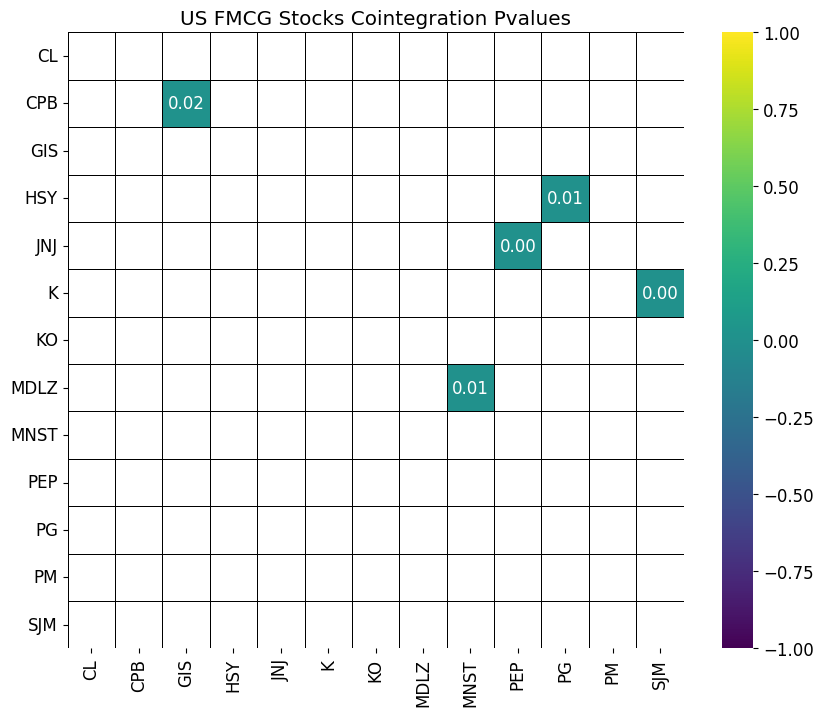

In [10]:
plt.figure(figsize = (10,8))
plt.rcParams.update({'font.size': 12})
plt.title("US FMCG Stocks Cointegration Pvalues")
sns.heatmap(pvalue_fmcg, cmap='viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5, linecolor='black'
            , xticklabels=train_fmcg.columns, yticklabels=train_fmcg.columns, mask = (pvalue_fmcg >= 0.05))
pairs_fmcg

Similarly for other sectors,

In [11]:
_, pvalue_tech, pairs_tech = find_cointegrated_pairs(train_tech)
_, pvalue_pharma, pairs_pharma = find_cointegrated_pairs(train_pharma)
_, pvalue_bank, pairs_bank = find_cointegrated_pairs(train_bank)


In [12]:
print("FMCG Pairs : "+str(pairs_fmcg))
print("Tech Pairs : "+str(pairs_tech))
print("Pharma Pairs : "+str(pairs_pharma))
print("Bank Pairs : "+str(pairs_bank))

FMCG Pairs : [('CPB', 'GIS'), ('HSY', 'PG'), ('JNJ', 'PEP'), ('K', 'SJM'), ('MDLZ', 'MNST')]
Tech Pairs : [('ADBE', 'CSCO'), ('ADBE', 'MSFT'), ('CRM', 'CSCO'), ('CRM', 'INTC'), ('CRM', 'MSFT'), ('CSCO', 'MSFT')]
Pharma Pairs : [('AMGN', 'MDT'), ('BMY', 'CVS'), ('CVS', 'GILD')]
Bank Pairs : [('BK', 'MS'), ('BK', 'SCHW'), ('C', 'GS'), ('C', 'MS'), ('COF', 'DFS'), ('COF', 'STT'), ('COF', 'USB'), ('COF', 'WFC'), ('JPM', 'SCHW'), ('PNC', 'SCHW'), ('SCHW', 'TFC')]


In [13]:
coint_pairs = np.concatenate([pairs_fmcg, pairs_tech, pairs_pharma, pairs_bank])


Kalman Filtering

In [14]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

#--------------------------------------------------------------------------------------

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

#--------------------------------------------------------------------------------------

def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

#--------------------------------------------------------------------------------------

#  Kalman filter regression
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means


In [15]:
def getHedgeRatio(s1, s2, x, y):
    df1 = pd.DataFrame({'y':y.values,'x':x.values})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    hr = - state_means[:,0]
    spread = df1.y + (df1.x * hr)
    return hr, spread

In [16]:
# for x in coint_pairs:
#     print(train_comb[x[0]].shape)

train_comb['JNJ']

Date
2010-01-04     64.680000
2010-01-05     63.930000
2010-01-06     64.449997
2010-01-07     63.990002
2010-01-08     64.209999
                 ...    
2018-12-21    128.089996
2018-12-24    122.839996
2018-12-26    126.709999
2018-12-27    127.410004
2018-12-28    127.269997
Name: JNJ, Length: 2263, dtype: float64

In [17]:
df_spread = pd.DataFrame()
df_hedge = pd.DataFrame()
for i in coint_pairs:
    df_spread[i[0]+'-'+i[1]] = getHedgeRatio(i[0], i[1], train_comb[i[0]], train_comb[i[1]])[1]
    df_hedge[i[0]+'-'+i[1]] = getHedgeRatio(i[0], i[1], train_comb[i[0]], train_comb[i[1]])[0]



In [18]:
df_spread

,CPB-GIS,HSY-PG,JNJ-PEP,K-SJM,MDLZ-MNST,ADBE-CSCO,ADBE-MSFT,CRM-CSCO,CRM-INTC,CRM-MSFT,...,BK-SCHW,C-GS,C-MS,COF-DFS,COF-STT,COF-USB,COF-WFC,JPM-SCHW,PNC-SCHW,SCHW-TFC
0,2.183423,3.513810,1.943524,2.588825,0.250370,1.385251,1.736473,2.793545,2.362463,3.501832,...,1.465733,10.618405,1.896319,0.777485,2.365980,1.217580,1.453859,0.956912,0.762040,2.758812
1,1.461831,1.769659,2.449750,1.768867,0.103956,0.762487,1.054563,2.167367,1.891242,2.820786,...,0.978616,6.221497,1.499784,0.573462,0.821876,0.774610,0.962782,0.474445,0.438020,2.462670
2,1.801094,1.872977,1.092105,1.747781,0.141252,0.625903,0.864987,1.808181,1.629796,2.356190,...,0.817985,-0.080834,0.864615,0.361279,0.090166,0.804893,0.780071,0.084477,0.125400,2.848252
3,2.348163,2.013628,1.035755,0.955432,0.129858,1.114006,1.061945,1.861630,1.393654,1.993740,...,0.020753,3.383530,1.166975,-0.189506,-0.854028,0.164684,0.456399,-0.223158,-0.742927,3.582429
4,2.031259,2.015122,0.649023,1.200135,0.137749,1.259824,1.338657,1.835291,1.500982,2.041651,...,-0.118570,3.291452,0.972481,-0.030933,0.673559,0.441543,0.465550,-0.164377,-0.671933,3.089532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,3.106542,0.917504,4.275551,0.982183,-1.188573,1.918452,4.536609,1.470329,2.713688,2.831417,...,0.381693,7.111232,2.469138,-0.151831,2.847123,0.777557,2.181985,0.749528,1.220080,0.904125
2259,4.051111,-0.347376,4.840860,1.078493,-0.495186,1.013789,1.966293,0.497241,1.937572,0.098670,...,-0.312010,6.271521,2.357993,-0.152913,3.537459,0.883818,1.536581,0.665312,0.882927,0.835185
2260,3.848850,0.586000,3.681908,0.568448,-0.185809,-0.121128,0.447425,-0.267449,1.267442,-0.600189,...,0.578226,6.115720,2.943360,0.089739,3.504346,0.335293,1.309681,1.337941,1.351894,0.104095
2261,4.953078,2.071922,3.907852,0.286923,-0.116871,-0.024096,0.161328,-1.003666,0.058106,-2.873377,...,0.523659,7.420457,2.889225,0.387069,3.210175,0.277237,0.882107,1.310347,1.434722,-0.089489


Variance Thresholding of the picked Spreads

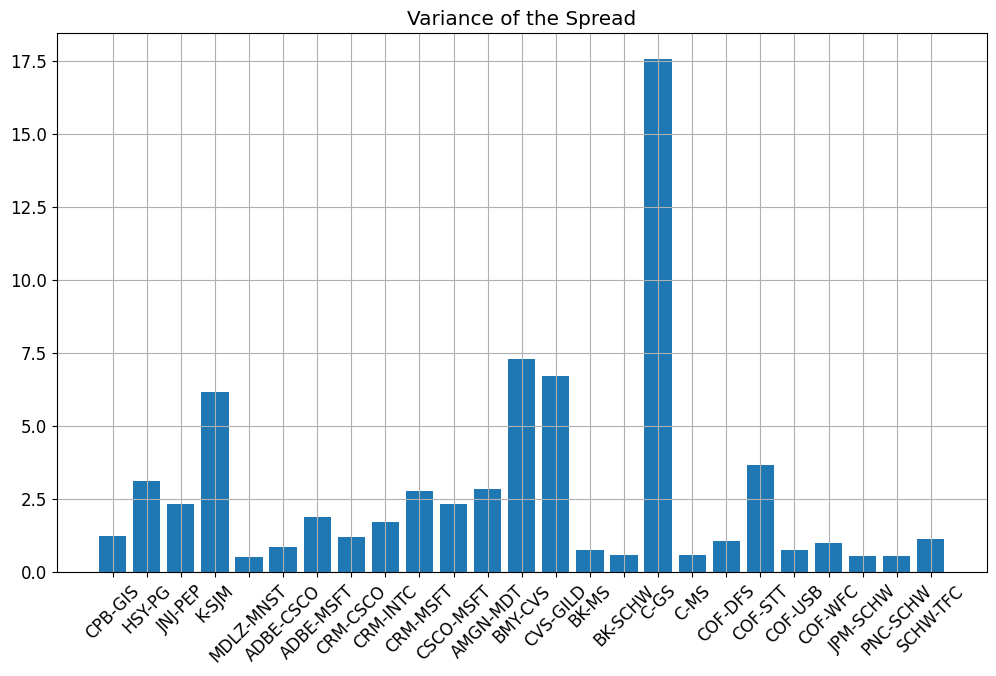

In [19]:
plt.figure(figsize=(12,7))
pairs_var = df_spread.var()
plt.xticks(rotation=45)
plt.bar(pairs_var.index, pairs_var.values)
plt.title("Variance of the Spread")
plt.grid()

In [20]:
# Pairs filtering by taking only 2 pairs per sector
def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name
        

pairs_filtered_1_set_count = {}
pairs_filtered_1_set = {}
pairs_filtered_1= []
for sector in sectors:
    pairs_filtered_1_set_count[get_var_name(sector)] = 0
    pairs_filtered_1_set[get_var_name(sector)] = []

# print(pairs_var.sort_values(ascending=False)[0])
pairs_var_sorted = pairs_var.sort_values(ascending=False)

for index, pair in pairs_var_sorted.items():
    for sector in sectors:
        if index.split('-')[0] in sector:
            if pairs_filtered_1_set_count[get_var_name(sector)] < 2:
                pairs_filtered_1_set_count[get_var_name(sector)] += 1
                pairs_filtered_1.append(index)
                pairs_filtered_1_set[get_var_name(sector)].append(index)
            else:
                break
print(pairs_filtered_1_set_count)
pairs_filtered_1_set

{'train_fmcg': 2, 'train_bank': 2, 'train_pharma': 2, 'train_tech': 2}


{'train_fmcg': ['K-SJM', 'HSY-PG'],
 'train_bank': ['C-GS', 'COF-STT'],
 'train_pharma': ['BMY-CVS', 'CVS-GILD'],
 'train_tech': ['CRM-MSFT', 'CSCO-MSFT']}

Generated a list of 2 stocks per industry to diversify the portfolio, now we need to pick the best out of the both

In [21]:
pairs_indices_combined = [(x,y,z,w) for x in range(2) for y in range(2) for z in range(2) for w in range(2)]
pairs_indices_combined

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1)]

In [22]:
pairs_combined = []
for i in pairs_indices_combined:
    new_pair = []
    new_pair.append(pairs_filtered_1_set[list(pairs_filtered_1_set.keys())[0]][i[0]])
    new_pair.append(pairs_filtered_1_set[list(pairs_filtered_1_set.keys())[1]][i[1]])
    new_pair.append(pairs_filtered_1_set[list(pairs_filtered_1_set.keys())[2]][i[2]])
    new_pair.append(pairs_filtered_1_set[list(pairs_filtered_1_set.keys())[3]][i[3]])
    pairs_combined.append(new_pair)
pairs_combined

[['K-SJM', 'C-GS', 'BMY-CVS', 'CRM-MSFT'],
 ['K-SJM', 'C-GS', 'BMY-CVS', 'CSCO-MSFT'],
 ['K-SJM', 'C-GS', 'CVS-GILD', 'CRM-MSFT'],
 ['K-SJM', 'C-GS', 'CVS-GILD', 'CSCO-MSFT'],
 ['K-SJM', 'COF-STT', 'BMY-CVS', 'CRM-MSFT'],
 ['K-SJM', 'COF-STT', 'BMY-CVS', 'CSCO-MSFT'],
 ['K-SJM', 'COF-STT', 'CVS-GILD', 'CRM-MSFT'],
 ['K-SJM', 'COF-STT', 'CVS-GILD', 'CSCO-MSFT'],
 ['HSY-PG', 'C-GS', 'BMY-CVS', 'CRM-MSFT'],
 ['HSY-PG', 'C-GS', 'BMY-CVS', 'CSCO-MSFT'],
 ['HSY-PG', 'C-GS', 'CVS-GILD', 'CRM-MSFT'],
 ['HSY-PG', 'C-GS', 'CVS-GILD', 'CSCO-MSFT'],
 ['HSY-PG', 'COF-STT', 'BMY-CVS', 'CRM-MSFT'],
 ['HSY-PG', 'COF-STT', 'BMY-CVS', 'CSCO-MSFT'],
 ['HSY-PG', 'COF-STT', 'CVS-GILD', 'CRM-MSFT'],
 ['HSY-PG', 'COF-STT', 'CVS-GILD', 'CSCO-MSFT']]

In [23]:
#getPortfolioVariance
ptf_risks = []

for i in pairs_combined:
    data = pd.DataFrame()
    for y in i:
        data[y] = df_spread[y]

    # print(data)
    # 1. Calculate Log Returns
    returns = np.log(data / data.shift(1)).dropna()
    # print(returns)
    # 2. Covariance Matrix
    cov_matrix = returns.cov()
    # print(cov_matrix)
    # 3. Portfolio Weights
    weights = np.ones(4)/4  # Example weights

    # 4. Portfolio Variance
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

    # 5. Portfolio Standard Deviation (Risk)
    portfolio_std_dev = np.sqrt(portfolio_variance)

    # Print Results
    print("For the pair "+ str(i))
    print("Portfolio Variance:", portfolio_variance)
    print("Portfolio Standard Deviation (Risk):", portfolio_std_dev)

    ptf_risks.append(portfolio_std_dev)


For the pair ['K-SJM', 'C-GS', 'BMY-CVS', 'CRM-MSFT']
Portfolio Variance: 0.13334961397777764
Portfolio Standard Deviation (Risk): 0.36517066418015787
For the pair ['K-SJM', 'C-GS', 'BMY-CVS', 'CSCO-MSFT']
Portfolio Variance: 0.11425477080243565
Portfolio Standard Deviation (Risk): 0.3380159327641756
For the pair ['K-SJM', 'C-GS', 'CVS-GILD', 'CRM-MSFT']
Portfolio Variance: 0.14886337809398686
Portfolio Standard Deviation (Risk): 0.38582817172154094
For the pair ['K-SJM', 'C-GS', 'CVS-GILD', 'CSCO-MSFT']
Portfolio Variance: 0.1332740856913484
Portfolio Standard Deviation (Risk): 0.365067234480648
For the pair ['K-SJM', 'COF-STT', 'BMY-CVS', 'CRM-MSFT']
Portfolio Variance: 0.1454420705013338
Portfolio Standard Deviation (Risk): 0.3813686805459171
For the pair ['K-SJM', 'COF-STT', 'BMY-CVS', 'CSCO-MSFT']
Portfolio Variance: 0.13011092269737076
Portfolio Standard Deviation (Risk): 0.3607089168531473
For the pair ['K-SJM', 'COF-STT', 'CVS-GILD', 'CRM-MSFT']
Portfolio Variance: 0.1638680766

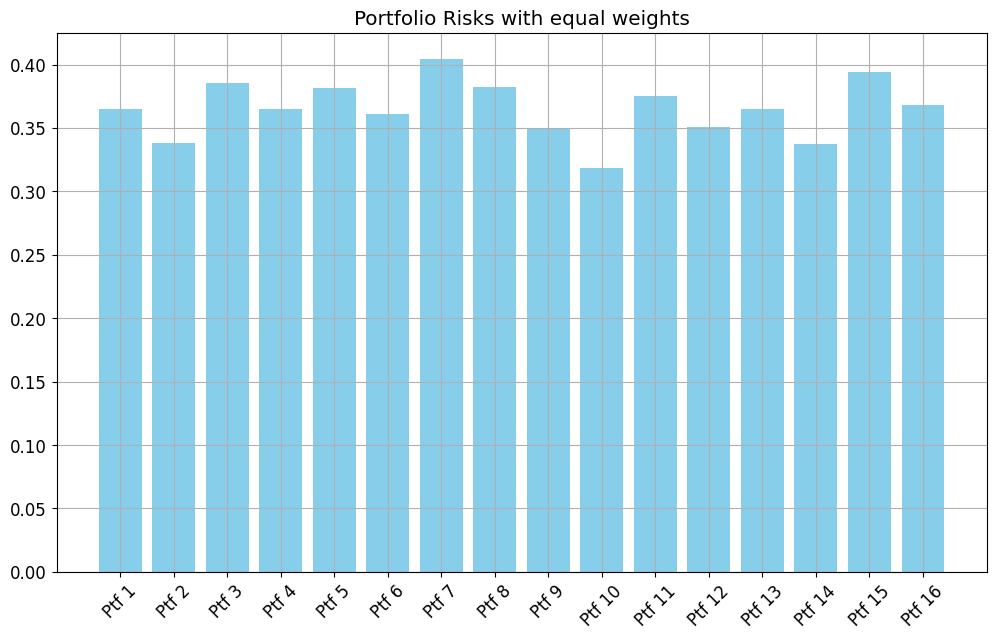

In [52]:
# Plotting the Risks with the Portfolio
plt.figure(figsize=(12,7))
plt.grid()
plt.xticks(rotation=45)
plt.title("Portfolio Risks with equal weights")
plt.bar(["Ptf "+str(i+1) for i in range(16)], ptf_risks, color='skyblue');

Pair 10 shows the minimum portfolio risk.

In [25]:
pairs_combined[9]

['HSY-PG', 'C-GS', 'BMY-CVS', 'CSCO-MSFT']

Optimizing the weights of the Pair 10

In [26]:
#data = DF with columns as spread
opt_weights_arr = []
opt_risk_arr = []
for portfolio_array in pairs_combined:
    # portfolio_array = pairs_combined[9]
    data = pd.DataFrame()
    for y in portfolio_array:
        data[y] = df_spread[y]
    print(data)
    print(data.shape)
    # 2. Calculate Log Returns
    returns = np.log(data / data.shift(1)).dropna()

    # 3. Calculate Covariance Matrix
    cov_matrix = returns.cov()

    # 4. Optimization Setup
    n_assets = len(data.columns)  # Number of stocks
    init_weights = np.ones(n_assets) / n_assets  # Equal weights initially
    bounds = tuple((0, 1) for _ in range(n_assets))  # No short-selling
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Sum of weights = 1

    # 5. Objective Function: Minimize Variance
    def portfolio_variance(weights, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    # 6. Optimization
    result = minimize(portfolio_variance, init_weights, args=(cov_matrix,), 
                    method='SLSQP', bounds=bounds, constraints=constraints)

    # 7. Results
    optimal_weights = result.x
    optimal_variance = result.fun
    print(str(portfolio_array))
    print(str(optimal_weights))
    print(str(optimal_variance))
    opt_weights_arr.append(optimal_weights)
    opt_risk_arr.append(np.sqrt(optimal_variance))

         K-SJM       C-GS   BMY-CVS  CRM-MSFT
0     2.588825  10.618405  2.704523  3.501832
1     1.768867   6.221497  2.370975  2.820786
2     1.747781  -0.080834  1.825218  2.356190
3     0.955432   3.383530  2.714387  1.993740
4     1.200135   3.291452  3.159921  2.041651
...        ...        ...       ...       ...
2258  0.982183   7.111232 -4.461771  2.831417
2259  1.078493   6.271521 -3.302368  0.098670
2260  0.568448   6.115720 -2.118308 -0.600189
2261  0.286923   7.420457 -2.387551 -2.873377
2262 -0.238011   4.832966 -2.710833 -2.776393

[2263 rows x 4 columns]
(2263, 4)
['K-SJM', 'C-GS', 'BMY-CVS', 'CRM-MSFT']
[0.22239875 0.33157418 0.24724118 0.19878589]
0.12869620851256136
         K-SJM       C-GS   BMY-CVS  CSCO-MSFT
0     2.588825  10.618405  2.704523   2.637183
1     1.768867   6.221497  2.370975   2.167347
2     1.747781  -0.080834  1.825218   1.894967
3     0.955432   3.383530  2.714387   1.326501
4     1.200135   3.291452  3.159921   1.314415
...        ...        ..

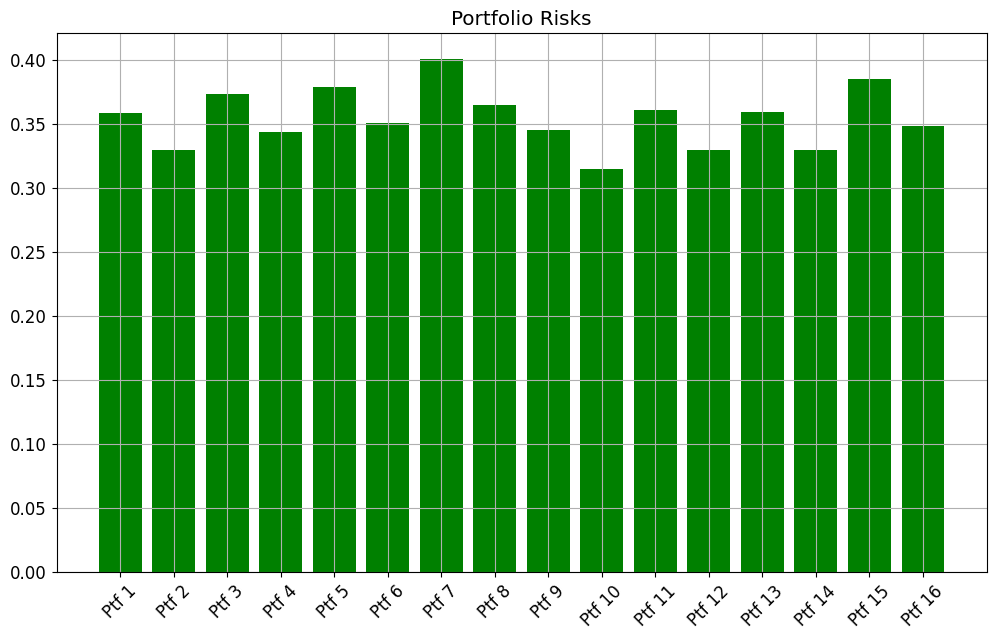

In [33]:
# Plotting the Risks with the Portfolio
plt.figure(figsize=(12,7))
plt.grid()
plt.xticks(rotation=45)
plt.title("Portfolio Risks")
plt.bar(["Ptf "+str(i+1) for i in range(16)], opt_risk_arr, color='green');

In [28]:
print(opt_risk_arr[9])
print(ptf_risks[9])

0.31522380378903503
0.31841841535556875


Even after optimization of the weight Pair 10 has the least covariance (Risk). Hence, continuing with Pair 10 : ['HSY-PG', 'C-GS', 'BMY-CVS', 'CSCO-MSFT']

In [29]:
best_weights = opt_weights_arr[9]
best_ptf = pairs_combined[9]
best_ptf

['HSY-PG', 'C-GS', 'BMY-CVS', 'CSCO-MSFT']

BACKTESTING

In [47]:
def backtest(spread, x, y, hr):

    df1 = pd.DataFrame()
    df1['spread'] = spread
    halflife = half_life(df1['spread'])
    print(halflife)
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()


    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################

    entryZscore = 1
    exitZscore = 0

    signalX = 0*x.copy()
    signalY = 0*y.copy()

    # Set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    signalX[df1['long entry'] == 1] = 1
    signalY[df1['long entry'] == 1] = -1
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    signalX[df1['long exit'] == 1] = -1
    signalY[df1['long exit'] == 1] = 1
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short
    df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    signalX[df1['long entry'] == 1] = 1
    signalY[df1['long entry'] == 1] = -1
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    signalX[df1['long entry'] == 1] = 1
    signalY[df1['long entry'] == 1] = -1
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((x * abs(hr)) + y)
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    #############################################################
    return df1['cum rets'], sharpe, signalX, signalY

In [ ]:
cum_ptf_returns = pd.DataFrame()
for i in range(len(best_ptf)):
    print(best_ptf[i])
    yo = (df_spread[best_ptf[i]])
    print(train_comb[best_ptf[i].split('-')[0]])
    cum_rets, sharpe, signalX, signalY = backtest(np.array(yo.values), train_comb[best_ptf[i].split('-')[0]].values, train_comb[best_ptf[i].split('-')[1]].values, 
                                df_hedge[best_ptf[i]].values)
    cum_rets *= best_weights[i]
    cum_ptf_returns[best_ptf[i]] = cum_rets
    cum_ptf_returns['Signal X ' + str(best_ptf[i])] = signalX
    cum_ptf_returns['Signal Y '  + str(best_ptf[i])] = signalY

cum_ptf_returns["TotalCum"] = cum_ptf_returns.sum(axis=1)
total_returns = cum_ptf_returns.iloc[-1].sum()
total_returns

HSY-PG
Date
2010-01-04     36.220001
2010-01-05     37.169998
2010-01-06     36.849998
2010-01-07     36.490002
2010-01-08     36.380001
                 ...    
2018-12-21    105.910004
2018-12-24    103.370003
2018-12-26    105.629997
2018-12-27    106.129997
2018-12-28    106.300003
Name: HSY, Length: 2263, dtype: float64
6
C-GS
Date
2010-01-04    34.000000
2010-01-05    35.299999
2010-01-06    36.400002
2010-01-07    36.500000
2010-01-08    35.900002
                ...    
2018-12-21    50.240002
2018-12-24    49.259998
2018-12-26    51.439999
2018-12-27    51.770000
2018-12-28    51.830002
Name: C, Length: 2263, dtype: float64
6
BMY-CVS
Date
2010-01-04    25.629999
2010-01-05    25.230000
2010-01-06    25.219999
2010-01-07    25.240000
2010-01-08    24.820000
                ...    
2018-12-21    49.820000
2018-12-24    48.759998
2018-12-26    50.029999
2018-12-27    50.410000
2018-12-28    50.939999
Name: BMY, Length: 2263, dtype: float64
8
CSCO-MSFT
Date
2010-01-04    24.690001

np.float64(4.003274813170437)

In [51]:
cum_ptf_returns

,HSY-PG,Signal X HSY-PG,Signal Y HSY-PG,C-GS,Signal X C-GS,Signal Y C-GS,BMY-CVS,Signal X BMY-CVS,Signal Y BMY-CVS,CSCO-MSFT,Signal X CSCO-MSFT,Signal Y CSCO-MSFT,TotalCum
0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.000000
1,0.226830,0.0,0.0,0.236847,0.0,0.0,0.222878,0.0,0.0,0.313445,0.0,0.0,1.000000
2,0.226830,0.0,0.0,0.236847,0.0,0.0,0.222878,0.0,0.0,0.313445,0.0,0.0,1.000000
3,0.226830,0.0,0.0,0.236847,0.0,0.0,0.222878,0.0,0.0,0.313445,0.0,0.0,1.000000
4,0.226830,0.0,0.0,0.236847,0.0,0.0,0.222878,0.0,0.0,0.313445,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,0.470244,0.0,0.0,0.433833,0.0,0.0,0.356578,0.0,0.0,0.735381,0.0,0.0,1.996036
2259,0.468605,1.0,-1.0,0.433833,0.0,0.0,0.358579,0.0,0.0,0.735381,0.0,0.0,1.996398
2260,0.469784,0.0,0.0,0.433833,1.0,-1.0,0.360564,-1.0,1.0,0.735381,0.0,0.0,1.999562
2261,0.471636,-1.0,1.0,0.434789,0.0,0.0,0.360564,0.0,0.0,0.735381,0.0,0.0,2.002370


In [53]:
for col in cum_ptf_returns.columns:
    if (col[:5] == 'Signal'):
        if col[7] == 'X':
            cum_ptf_returns[col] = cum_ptf_returns[col].where(cum_ptf_returns[col] != 0, cum_ptf_returns['column2'])

HSY-PG
Signal X HSY-PG
Signal Y HSY-PG
C-GS
Signal X C-GS
Signal Y C-GS
BMY-CVS
Signal X BMY-CVS
Signal Y BMY-CVS
CSCO-MSFT
Signal X CSCO-MSFT
Signal Y CSCO-MSFT
TotalCum


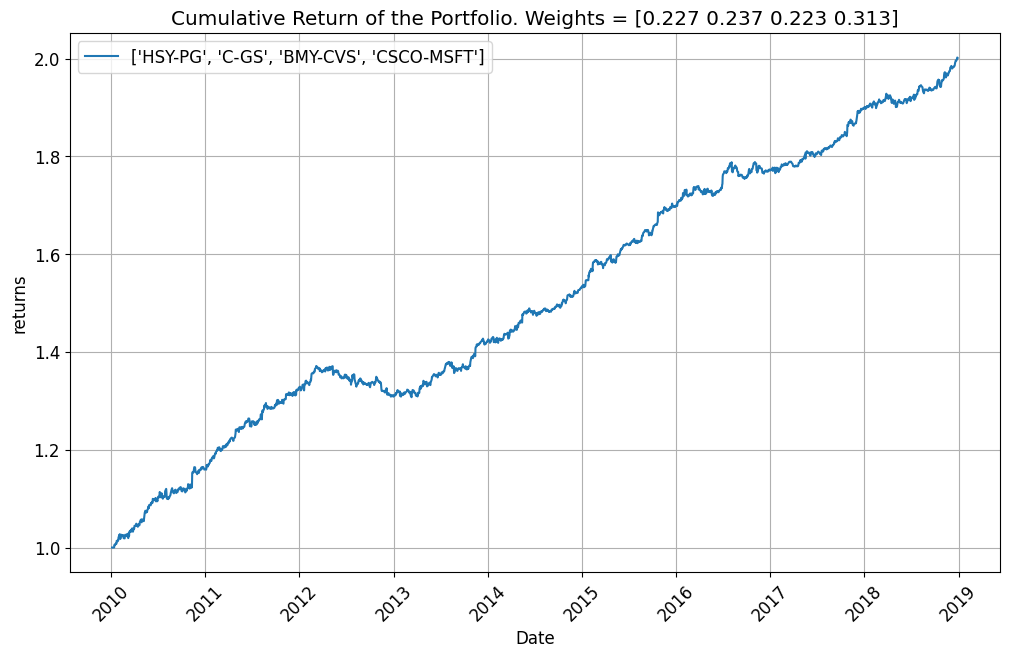

In [40]:
cum_ptf_returns.loc[0, "TotalCum"] = 1
plt.figure(figsize=(12,7))
plt.xticks(rotation=45)
plt.plot(train_comb.index, cum_ptf_returns["TotalCum"])
plt.title("Cumulative Return of the Portfolio. Weights = "+str(best_weights.round(decimals=3)))
plt.xlabel("Date")
plt.ylabel("returns")
plt.legend([best_ptf])
plt.grid()

Text(0.5, 1.0, 'Ptf Stock prices')

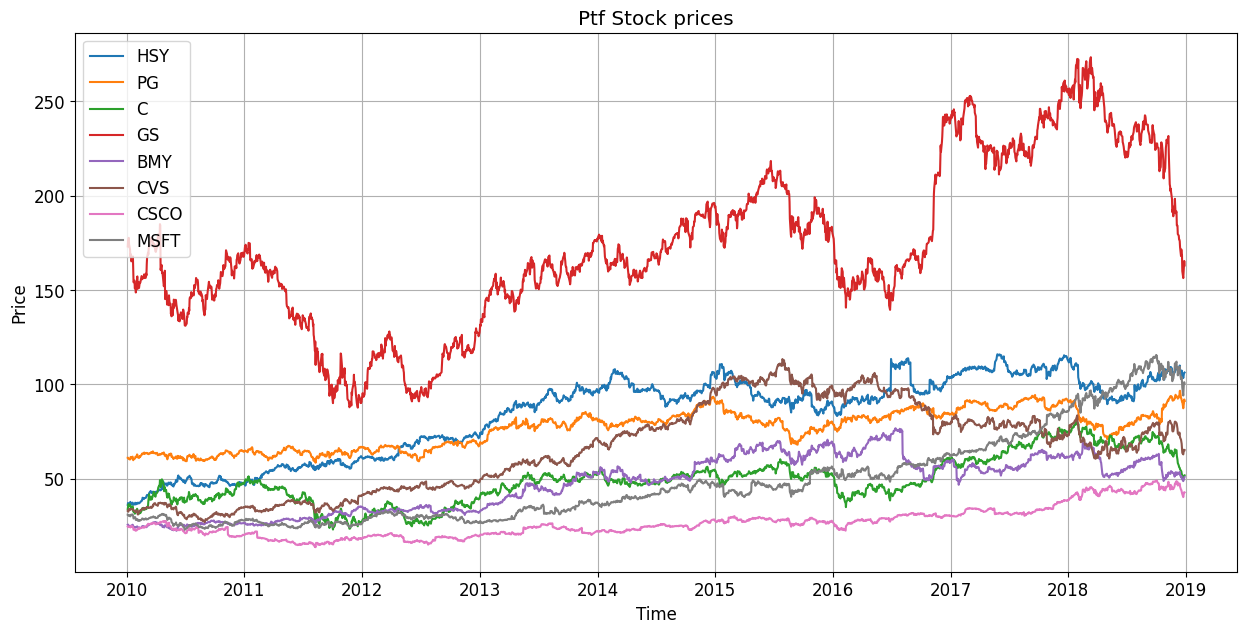

In [41]:
plt.figure(figsize=(15,7))
for x in best_ptf:
    plt.plot(train_comb[x.split('-')[0]], label=x.split('-')[0])
    plt.plot(train_comb[x.split('-')[1]], label=x.split('-')[1])

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid()
plt.title("Ptf Stock prices")